# WHAT IS THIS NOTEBOOK ABOUT?

This notebook serves to test all the functions related to continuous variable forecast

### Contents
1. [Prophet](#PROPHET)
2. [LSTM](#LSTM)

The initial data can be retrieved from the folder in the share point. The data is the same that is to come from the previous task in the KubeFlow Pipeline.

# IMPORTS

In [3]:
import pandas as pd
from prophet import Prophet

In [5]:
data = pd.read_feather("test_data.feather")

# PROPHET

In [43]:
def Train_Prophet(train_data, num_days, measures_per_hour, diff_time):

    m = Prophet(daily_seasonality=True, weekly_seasonality=True, changepoint_prior_scale = 0.05)
    m.fit(train_data)
    future = m.make_future_dataframe(periods= 24*(2 + num_days)*measures_per_hour , freq="{minutes}T".format(minutes = diff_time))
    forecast = m.predict(future)

    forecast_test = forecast["yhat"].tolist()[-24*measures_per_hour*(2 + num_days):-24*measures_per_hour]

    return forecast, forecast_test, m

In [44]:
forecast, forecast_test, model = Train_Prophet(data, 1, 1, 60)

In [45]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3172,2023-05-10 19:00:00,6.330366,6.546263,7.482128,6.318592,6.340773,0.696313,0.696313,0.696313,0.777534,0.777534,0.777534,-0.081221,-0.081221,-0.081221,0.0,0.0,0.0,7.026679
3173,2023-05-10 20:00:00,6.330375,6.442276,7.418829,6.318275,6.341210,0.546072,0.546072,0.546072,0.625857,0.625857,0.625857,-0.079785,-0.079785,-0.079785,0.0,0.0,0.0,6.876447
3174,2023-05-10 21:00:00,6.330384,6.074333,7.043151,6.317733,6.341572,0.228149,0.228149,0.228149,0.306146,0.306146,0.306146,-0.077997,-0.077997,-0.077997,0.0,0.0,0.0,6.558533
3175,2023-05-10 22:00:00,6.330393,5.669587,6.633729,6.317451,6.341787,-0.215075,-0.215075,-0.215075,-0.139179,-0.139179,-0.139179,-0.075896,-0.075896,-0.075896,0.0,0.0,0.0,6.115317
3176,2023-05-10 23:00:00,6.330402,5.140242,6.140309,6.316828,6.342350,-0.683021,-0.683021,-0.683021,-0.609499,-0.609499,-0.609499,-0.073522,-0.073522,-0.073522,0.0,0.0,0.0,5.647381


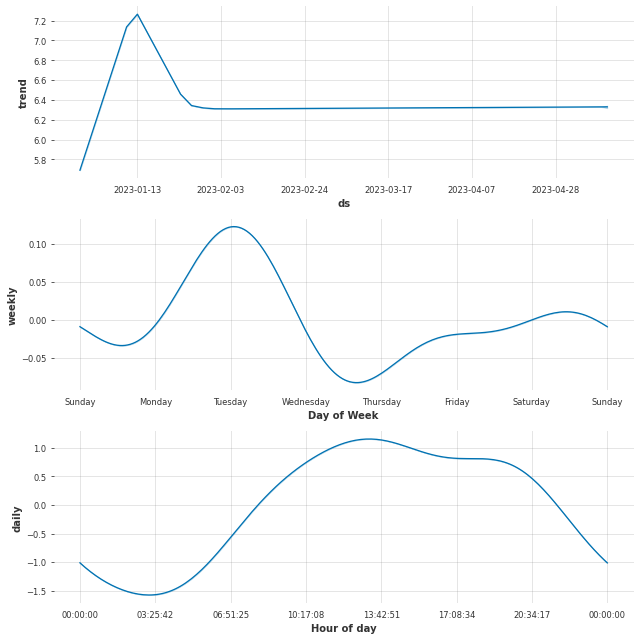

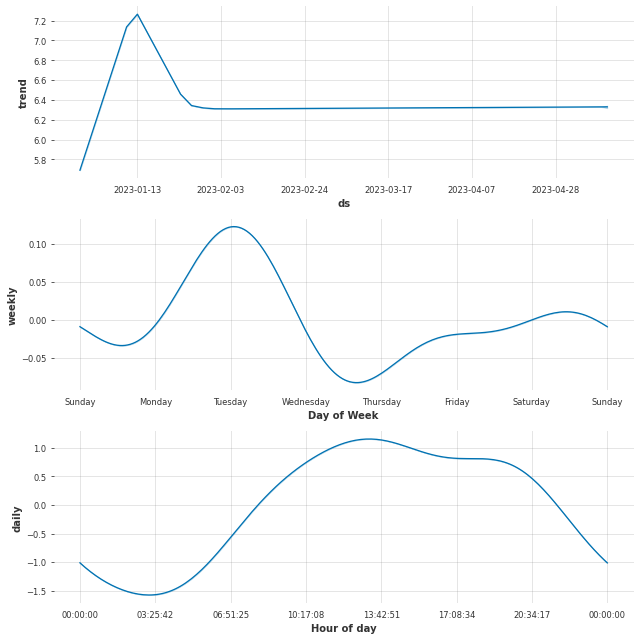

In [46]:
model.plot_components(forecast)

# LSTM

In [2]:
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, coefficient_of_variation, mae, mse, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
############ Warning and Logging Suppression ############
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [8]:
from darts.models import RNNModel

def Train_LSTM(data, split_proportion, diff_time=60, num_days=1, 
               measures_per_hour=1, n_epochs=100, batch_size=16):

    if not isinstance(data, pd.DataFrame) or 'ds' not in data.columns or 'y' not in data.columns:
        raise ValueError("The input data must be a pandas DataFrame with 'ds' and 'y' columns.")

    if not (0 < split_proportion < 1):
        raise ValueError("The split_proportion must be a float between 0 and 1.")

    # fill missing values with the last available value
    data = data.fillna(method='ffill')
    
    # Create a time series
    series = TimeSeries.from_dataframe(data, 'ds', 'y',fill_missing_dates=True, freq="{minutes}T".format(minutes = diff_time))

    # Create training and validation sets:
    train, val = series.split_after(pd.Timestamp(series.start_time() + pd.Timedelta(hours=int(len(series) * split_proportion))))

    # Normalize the time series (note: we avoid fitting the transformer on the validation set)
    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    series_transformed = transformer.transform(series)

    # create month and year covariate series
    year_series = datetime_attribute_timeseries(
        pd.date_range(start=series.start_time(), freq=series.freq_str, periods=len(series) * 2),
        attribute="year",
        one_hot=False,
    )
    year_series = Scaler().fit_transform(year_series)
    month_series = datetime_attribute_timeseries(
        year_series, attribute="month", one_hot=True
    )
    covariates = year_series.stack(month_series)
    cov_train, cov_val = covariates.split_after(pd.Timestamp(val.start_time() - pd.Timedelta(hours=1)))

    # predict *num_days* days ahead
    pred_ahead = 24 * (2 + num_days) * measures_per_hour

    my_model = RNNModel(
        input_chunk_length=2 * pred_ahead,
        model="LSTM",
        hidden_dim=25,
        n_rnn_layers=1,
        dropout=0.2,
        training_length=pred_ahead,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer_kwargs={"lr": 1e-3},
        model_name="data_RNN",
        log_tensorboard=True,
        random_state=42,
        force_reset=True,
        save_checkpoints=True,
    )

    my_model.fit(
        train_transformed,
        future_covariates=cov_train,
        val_series=val_transformed,
        val_future_covariates=cov_val,
        verbose=True,
    )

    # Make forecasts
    forecast = my_model.predict(n=pred_ahead, future_covariates=covariates)

    # Inverse-transform forecasts and obtain the real predicted values
    forecast = transformer.inverse_transform(forecast)

    # Compute the mean absolute percentage error (MAPE)
    print("Test Coefficient of Variation: {:.2f}".format(coefficient_of_variation(forecast, val)))
    print("Test Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape(forecast, val)))
    print("Test Mean Absolute Error (MAE): {:.2f}".format(mae(forecast, val)))
    print("Test Mean Squared Error (MSE): {:.2f}".format(mse(forecast, val)))
    print("Test Root Mean Squared Error (RMSE): {:.2f}".format(rmse(forecast, val)))

    return forecast, series, val, my_model



In [9]:
def eval_model(forecast, series, validation):
        plt.figure(figsize=(8, 5))
        series.slice(forecast.start_time(), forecast.end_time()).plot(label="actual")
        forecast.plot(label="forecast")
        plt.title("MAPE: {:.2f}%".format(mape(forecast, validation)))
        plt.legend()
        plt.show()

In [ ]:
forecast, series, validation, lstm_model = Train_LSTM(data = data, split_proportion = 0.9,  
                                                      diff_time = 60, num_days = 1, 
                                                      measures_per_hour = 1, n_epochs = 50)

- *Test Coefficient of Variation:* **3.96**
- *Test Mean Absolute Percentage Error (MAPE):* **3.09%**
- *Test Mean Absolute Error (MAE):* *0.18*
- *Test Mean Squared Error (MSE):* **0.06**
- *Test Root Mean Squared Error (RMSE):* **0.25**

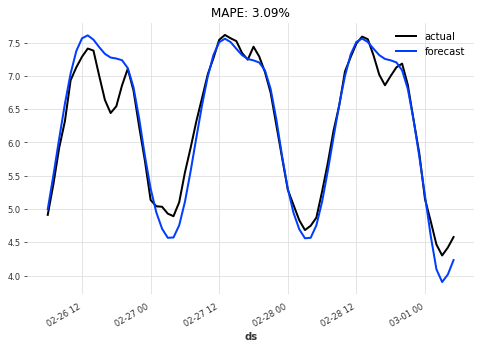

In [31]:
eval_model(forecast, series, validation)

# TRANSFORMERS

In [32]:
from darts.models import TransformerModel

def Train_Transformer(data, split_proportion, diff_time=60, num_days=1,
                      measures_per_hour=1, n_epochs=100, batch_size=16):

    if not isinstance(data, pd.DataFrame) or 'ds' not in data.columns or 'y' not in data.columns:
        raise ValueError("The input data must be a pandas DataFrame with 'ds' and 'y' columns.")

    if not (0 < split_proportion < 1):
        raise ValueError("The split_proportion must be a float between 0 and 1.")

    # Fill missing values with the last available value
    data = data.fillna(method='ffill')

    # Create a time series
    series = TimeSeries.from_dataframe(data, 'ds', 'y', fill_missing_dates=True, freq="{minutes}T".format(minutes = diff_time))
    
    # Create training and validation sets:
    train, val = series.split_after(pd.Timestamp(series.start_time() + pd.Timedelta(hours=int(len(series) * split_proportion))))
    
    # Normalize the time series (note: we avoid fitting the transformer on the validation set)
    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    series_transformed = transformer.transform(series)

    # predict num_days days ahead
    pred_ahead = 24 * (2 + num_days) * measures_per_hour 

    my_model = TransformerModel(
        input_chunk_length = 2 * pred_ahead,
        output_chunk_length = pred_ahead,
        batch_size = batch_size,
        n_epochs = n_epochs,
        model_name = "data_transformer",
        optimizer_kwargs={"lr": 1e-3},
        d_model = 16,
        nhead = 4,
        num_encoder_layers = 2,
        num_decoder_layers = 2,
        dim_feedforward = 128,
        dropout = 0.2,    
        activation = "relu",
        random_state = 42,
        log_tensorboard = True,
        force_reset = True,
        save_checkpoints=True,
    )

    my_model.fit(
        train_transformed,
        val_series=val_transformed,
        verbose=True,
    )

    # Make forecasts
    forecast = my_model.predict(n=pred_ahead)

    # Inverse-transform forecasts and obtain the real predicted values
    forecast = transformer.inverse_transform(forecast)

    # Compute the mean absolute percentage error (MAPE) and other error metrics
    print("Test Coefficient of Variation: {:.2f}".format(coefficient_of_variation(forecast, val)))
    print("Test Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape(forecast, val)))
    print("Test Mean Absolute Error (MAE): {:.2f}".format(mae(forecast, val)))
    print("Test Mean Squared Error (MSE): {:.2f}".format(mse(forecast, val)))
    print("Test Root Mean Squared Error (RMSE): {:.2f}".format(rmse(forecast, val)))

    return forecast, series, val, my_model

In [ ]:
forecast, series, validation, transformer_model = Train_Transformer(data = data, split_proportion = 0.9,  
                                                                    diff_time = 60, num_days = 1, 
                                                                    measures_per_hour = 1, n_epochs = 50)

- *Test Coefficient of Variation:* **3.88**
- *Test Mean Absolute Percentage Error (MAPE):* **3.40%**
- *Test Mean Absolute Error (MAE):* **0.21**
- *Test Mean Squared Error (MSE):* **0.06**
- *Test Root Mean Squared Error (RMSE):* **0.24**

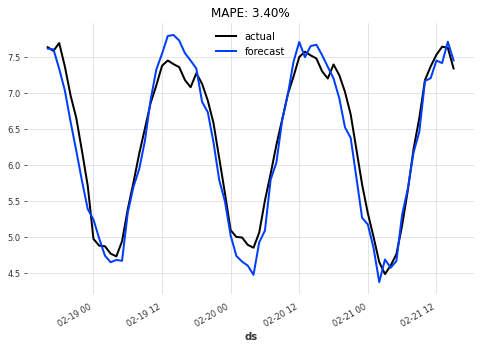

In [37]:
eval_model(forecast, series, validation)